# Example 3: Identification of a System with a Nonlinear Response to Input and State

In this example, the system dynamics are defined by:

$y_p(k + 1) = f(y_p(k)) + g(u(k))$

where:

$ f(y_p(k)) = \frac{y_p(k)}{1 + y_p(k)^2} $

$g(u(k)) = u(k)^3 $

Two neural networks are used: 

$N_f$ approximates $f(y_p)$

$N_g$ approximates $g(u)$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)

In [2]:
# Define parameters
# k_ = 100_000  # Total number of steps
k_ = 100  # Total number of steps

# Training phase: Generate random input u(k) in range [-2, 2]
# u_train = np.random.uniform(low=-2, high=2, size=(k_))
# u = np.sin(2 * np.pi * np.arange(k_) / 25) + np.sin(2 * np.pi * np.arange(k_) / 10)
u_train = np.linspace(-2, 2, k_)

# Initialize the true plant output y_p
y_p_train = np.linspace(-10, 10, k_)
# y_p_train = np.zeros(k_)
# y_p_train = np.random.uniform(low=-10, high=10, size=(k_))


# Define plant function f(y_p(k)) and g(u(k))
def f(y_p):
    """Nonlinear function of the plant's previous output."""
    return y_p / (1 + np.power(y_p, 2))

def g(u):
    """Nonlinear function of the plant's input."""
    return np.power(u, 3)

g_seq = g(u_train)
f_seq = f(y_p_train)

for k in range(0, k_ - 1):
    y_p_train[k + 1] = f_seq[k] + g_seq[k]


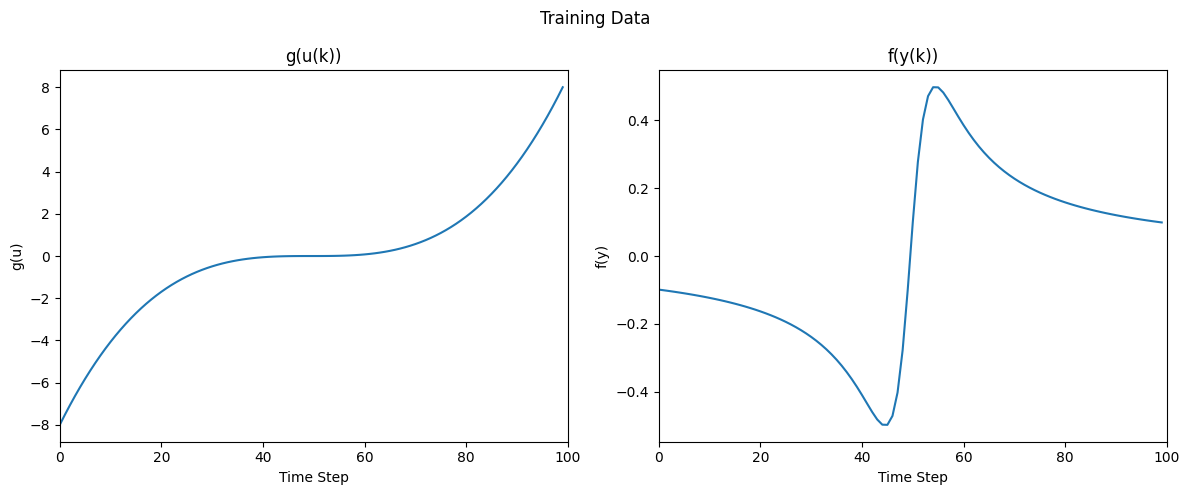

In [3]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

fig.suptitle("Training Data")

ax[0].plot(g_seq)
ax[0].set_title("g(u(k))")
ax[0].set_ylabel("g(u)")
ax[0].set_xlabel("Time Step")
ax[0].set_xlim([0, k_])

ax[1].plot(f_seq)
ax[1].set_title("f(y(k))")
ax[1].set_ylabel("f(y)")
ax[1].set_xlabel("Time Step")
ax[1].set_xlim([0, k_])

plt.tight_layout()

plt.savefig("training_data.svg", dpi=300)
plt.show()

In [4]:
# Neural network model architecture
N_f = nn.Sequential(nn.Linear(1, 20), nn.Tanh(), nn.Linear(20, 10), nn.Tanh(), nn.Linear(10, 1))
N_g = nn.Sequential(nn.Linear(1, 20), nn.Tanh(), nn.Linear(20, 10), nn.Tanh(), nn.Linear(10, 1))

# Define optimizer and loss
learning_rate = 0.1
optimizer = optim.Adam(list(N_f.parameters()) + list(N_g.parameters()), lr=learning_rate)
criterion = nn.MSELoss()


In [ ]:
# Convert to tensors for PyTorch
u_train_ = torch.from_numpy(u_train).view(-1, 1).float()
y_p_train_ = torch.from_numpy(y_p_train).float()
y_hat_train = np.zeros(k_)

# Training loop
num_epochs = 200  # Set a lower number initially for testing
for epoch in range(num_epochs):
    epoch_loss = 0
    for k in range(2, k_ - 1):
        optimizer.zero_grad()

        # Predict f(y_p) and g(u) using the neural networks
        f_pred = N_f(y_p_train_[k].view(-1, 1))
        g_pred = N_g(u_train_[k].view(-1, 1))

        # Calculate y_hat(k + 1)
        y_hat_ = (f_pred + g_pred).squeeze()
        y_hat_train[k + 1] = y_hat_.detach().numpy()

        # Calculate loss
        loss = criterion(y_hat_, y_p_train_[k + 1])
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss / (k_ - 2):.5f}")

# Testing phase: Generate deterministic input signal u_test for evaluation
k_test = 700  # Smaller test length for quick visualization
u_test = np.sin(2 * np.pi * np.arange(k_test) / 25) + np.sin(2 * np.pi * np.arange(k_test) / 10)

# Calculate the true plant output y_p_test with the deterministic input signal
y_p_test = np.zeros(k_test)
for k in range(2, k_test - 1):
    y_p_test[k + 1] = f(y_p_test[k]) + g(u_test[k])

# Predict the output y_hat_test using the trained model
u_test_ = torch.from_numpy(u_test).view(-1, 1).float()
y_hat_test = np.zeros(k_test)

with torch.no_grad():
    for k in range(2, k_test - 1):
        f_pred = N_f(torch.tensor(y_hat_test[k]).view(-1, 1).float())
        g_pred = N_g(u_test_[k].view(-1, 1))
        y_hat_test[k + 1] = (f_pred + g_pred).item()

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(y_p_test, label="True Plant Output (y_p)")
plt.plot(y_hat_test, label="Model Output (y_hat)", linestyle="--")
plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Output")
plt.title("Example 3: Model Output vs True Plant Output")
plt.show()
